## FaceRecognition 16/06/2020

Identification of side faces on different test images.

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from imageio import imread
from skimage.transform import resize
from keras.models import load_model
import keras
from mtcnn.mtcnn import MTCNN
import tensorflow as tf

%matplotlib inline

Using TensorFlow backend.


In [3]:
image_dir_basepath = './cropped/train/'    # path to the training dataset directory
names = ['Anne_Hathaway', 'Ayushmann_Khurrana', 'Brad_Pitt','Irrfan_Khan','Jen_Aniston',
         'Jen_Lawrence','Johnny_Depp','Pankaj_Tripathi','Robert_DowneyJr','Will_Smith']
        # list of labels
image_size = 160

In [4]:
model_path = './model/keras/model/facenet_keras.h5'   # path to the predefined keras model for facenet
model = load_model(model_path)

C:\Users\HP\anaconda3\envs\face_recog\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

In [6]:
#define the training hyperparameters

epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

In [7]:
#compile the model

model.compile(loss=['categorical_crossentropy'], 
              loss_weights=[1], optimizer=sgd, metrics=['accuracy'])
model.save('./model_0806.h5')

In [8]:
#print(model.summary())

In [9]:
import pathlib

data_dir='./cropped/train/'   #path of training directory
data_dir = pathlib.Path(data_dir)

data_dr='./cropped/valid/'    #path of valid_set directory
data_dr = pathlib.Path(data_dr)

image_count = len(list(data_dir.glob('*/*.jpg')))

# generator for training set and valid set. The training data generator employs data augmentation in form of flips and zooms.

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  shear_range=0.2,zoom_range=0.2,
                                                                  rotation_range=90,width_shift_range=0.1,
                                                                  height_shift_range=0.1,horizontal_flip=True)

BATCH_SIZE = 32
IMG_HEIGHT = 160
IMG_WIDTH = 160
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

# name of classes
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

#iterable form of generators

train_data_gen = train_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

valid_data_gen = image_generator.flow_from_directory(directory=str(data_dr),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

images,labels=next(train_data_gen)
x_test,y_test=next(valid_data_gen)

Found 1612 images belonging to 10 classes.
Found 358 images belonging to 10 classes.


In [10]:
# the function prewhiten and l2_normalize subtract the average and 
# normalize the range of the pixel values of input images respectively.

def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [11]:
# the function deals with cropping of image along the detected face

def load_and_align_images(filepaths, margin):
    
    aligned_images = []
    for filepath in filepaths:
        img = plt.imread(filepath)
        detector = MTCNN()
        # detect faces in the image
        faces = detector.detect_faces(img)
        
        if(len(faces)==0):
            continue
        for face in faces:
            (x, y, w, h) = face['box']
            y2=y+h
            x2=x+w
            cropped = img[y:y2,x:x2]
            if(cropped.shape[0]==0 or cropped.shape[1]==0 or cropped.shape[2]==0):
                continue
            aligned = resize(cropped, (image_size, image_size), mode='reflect')
            aligned_images.append(aligned)
            
    return np.array(aligned_images)

In [12]:
# the function is used to find the respective encoding of the images

def calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [13]:
# training of the data set
def train(dir_basepath, names, max_num_img=10):
    labels = []
    embs = []
    for name in names:
        dirpath = os.path.abspath(dir_basepath + name)
        filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)][:max_num_img]
        embs_ = calc_embs(filepaths)    
        labels.extend([name] * len(embs_))
        embs.append(embs_)
        
    embs = np.concatenate(embs)
    le = LabelEncoder().fit(labels)
    y = le.transform(labels)
    clf = SVC(kernel='rbf', probability=True).fit(embs, y)
    return le, clf

In [14]:
le, clf = train(image_dir_basepath, names)

In [30]:
# predicting the class of the input images

def infer(le, clf, filepaths):
    pred=[]
    pred_prob=[]
    embs = calc_embs(filepaths)
    x=clf.predict(embs)
    y_score=clf.predict_proba(embs)
    for y in y_score:
        pred_prob.append(names[np.argmax(y)])
    pred = le.inverse_transform(x)
    return pred,pred_prob

In [31]:
test_dirpath = os.path.join('./images/new')# path to the test dataset
test_filepaths = [os.path.join(test_dirpath, f) for f in os.listdir(test_dirpath)]

In [32]:
pred,pred_prob= infer(le, clf, test_filepaths)

In [33]:
from skimage import transform
from keras.preprocessing import image
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
k=0

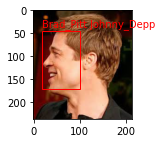

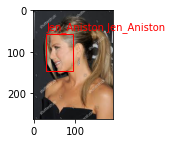

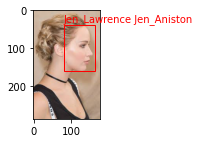

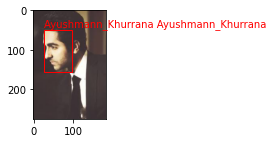

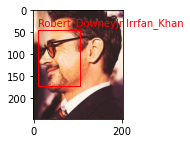

In [34]:
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (160,160, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

# draw each face separately
def draw_faces(filename, result_list,k):
    # load the image
    data = plt.imread(filename)
    fig, axes = plt.subplots(1,1, figsize=(2, 2))
    axes.imshow(data)
    h,w,c=data.shape
    # plot each face as a subplot
    for i in range(len(result_list)):
        # get coordinates
        x1, y1, width, height = result_list[i]['box']
        x2, y2 = x1 + width, y1 + height
        rect = Rectangle((x1,y1),width,height,linewidth=1,edgecolor='r',facecolor='none')
        plt.text(x1, y1-10,pred[k]+" "+pred_prob[k], fontsize=10,color='r')
        k+=1
        axes.add_patch(rect)
    # show the plot
    plt.show()
    return k

    
for i in range(len(test_filepaths)): 
    pixels = plt.imread(test_filepaths[i])
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    faces = detector.detect_faces(pixels)
    # display faces on the original image
    k=draw_faces(test_filepaths[i], faces,k)

In [37]:
# the predicted labels match the correct labels 
from sklearn.metrics import accuracy_score,f1_score

y = ['Brad_Pitt','Jen_Aniston','Jen_Lawrence','Ayushmann_Khurrana','Robert_DowneyJr']

print("From .predict():")
print(accuracy_score(y,pred))
print(f1_score(y,pred,average='weighted'))

print("\nFrom .predict_proba():")
print(accuracy_score(y,pred_prob))
print(f1_score(y,pred_prob,average='weighted'))

From .predict():
1.0
1.0

From .predict_proba():
0.4
0.3333333333333333


The model used here is keras-facenet which is used for feature extraction of the images. 

The model is able to detect the celebrities with an accuracy of 1.0 and f1-score of 1.0

To check for the threshold, predict_proba function of sklearn is used. However, predict_proba and predict reults vary significantly.predict_proba generally produces an erroneous answer. 

In the above results, the first string represents the result from predict whereas the second string represents the results from predicgt_proba